## Expedia hotel recommendation

Using leakage information attempt to identify users based on user city and origin-destination distance.
___

In [1]:
# Import libraries

import operator, datetime
import ml_metrics
import pandas as pd
import numpy as np
from sklearn.cross_validation import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [72]:
def formatdata(chunk):
    '''Format data of each startified chunk.'''
    
    # fill or drop NAs for origin-destination distance
    chunk['orig_destination_distance'].fillna(0.0, inplace=True)
    chunk['orig_destination_distance'].round(4)
    # chunk.dropna(axis=0, subset=['orig_destination_distance'], inplace=True)
      
    return chunk

def stratshufspl(chunk, fraction, ylabel):
    '''Startified shuffle split of chunks.'''
    sss = StratifiedShuffleSplit(chunk[ylabel], test_size=fraction, 
                                 random_state=42, n_iter=1)
    for _, idx in sss:
        train = chunk.iloc[idx].copy()
    return train


def fractionate(trainiter, fraction, ylabel):
    '''Utilizes only one core.'''
    print('')
    print('loading data...')
    
    # create empty list and add formatted data chunks
    chunks = list()
    for chunk in trainiter:
        # chunk = chunk[chunk['is_booking']==1]   # train only on booking events
        # if using whole dataset skip this step
        if fraction < 1.0:
            chunk = stratshufspl(chunk, fraction, ylabel)
        curr = formatdata(chunk)
        chunks.append(curr)
        
    # concatenate chunks
    train = pd.concat(chunks, axis=0)
    
    # split concatenated set into X and y for ml model fitting
    # X = train.drop([ylabel, 'is_booking'], axis=1, inplace=False)
    # y = train[ylabel]
    return train

## Load data

In [73]:
dataurl = '/Users/dbricare/Documents/Python/datasets/expedia/'

rawcols = ['srch_destination_id', 'user_location_country', 
           'user_location_region', 'user_location_city', 
           'hotel_market', 'orig_destination_distance', 
           'is_booking','hotel_cluster']

ylabel = rawcols[-1]

csviter = pd.read_csv(dataurl+'train.csv.gz', sep=',', compression='gzip', chunksize=2000000, usecols=rawcols)

Xy = fractionate(csviter, 1, rawcols[-1])

print(Xy.shape)
print(Xy.columns)
Xy.head()


loading data...
(37670293, 8)
Index(['user_location_country', 'user_location_region', 'user_location_city',
       'orig_destination_distance', 'srch_destination_id', 'is_booking',
       'hotel_market', 'hotel_cluster'],
      dtype='object')


,user_location_country,user_location_region,user_location_city,orig_destination_distance,srch_destination_id,is_booking,hotel_market,hotel_cluster
0,66,348,48862,2234.2641,8250,0,628,1
1,66,348,48862,2234.2641,8250,1,628,1
2,66,348,48862,2234.2641,8250,0,628,1
3,66,442,35390,913.1932,14984,0,1457,80
4,66,442,35390,913.6259,14984,0,1457,21


Most common hotel clusters: [91, 48, 42, 59, 28]


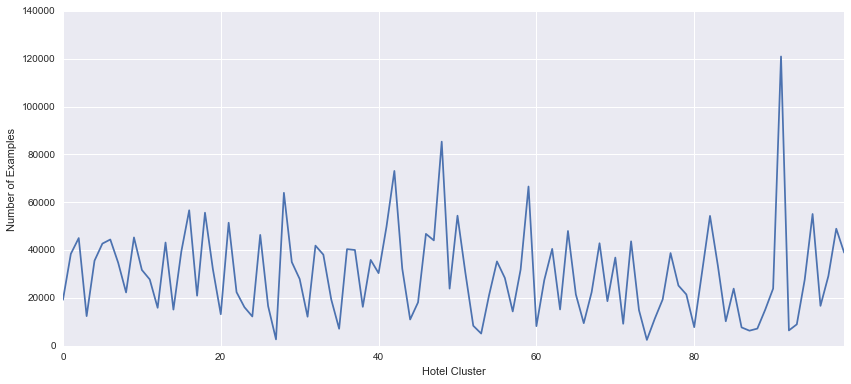

In [69]:
# Distribution of hotel cluster occurrences

f = Xy['hotel_cluster'].value_counts(sort=False).plot(figsize=(14,6))
mostcommon = Xy['hotel_cluster'].value_counts(sort=True).iloc[:5].index.tolist()
print('Most common hotel clusters:', mostcommon)
_ = f.set_ylabel('Number of Examples')
_ = f.set_xlabel('Hotel Cluster')

In [4]:
# divide data into train and test sections

sss = StratifiedShuffleSplit(Xy[Xy.columns[-1]], n_iter=1, test_size=0.2)
for trainidx, testidx in sss:
    # Xtrain, ytrain = Xy[Xy.columns[:-1]].iloc[trainidx], Xy[Xy.columns[-1]].iloc[trainidx]
    Xytrain = Xy.iloc[trainidx]
    Xtest, ytest = Xy[Xy.columns[:-1]].iloc[testidx], Xy[Xy.columns[-1]].iloc[testidx]

## Predict 5 top occurring hotel clusters based on `srch_destination_id`

In [101]:
# # create dictionary of destination IDs and counter including number of occurrences
# # for each hotel cluster

# match_cols = ["srch_destination_id"]
# cluster_cols = match_cols + ['hotel_cluster']

# # group on destination ID then hotel cluster
# groups = Xy.groupby(cluster_cols)

# top_clusters = {}
# for idx, data in groups:
#     clicks = len(data.is_booking[data.is_booking == False])
#     bookings = len(data.is_booking[data.is_booking == True])
#     score = bookings + .15 * clicks
#     cluster_name = str(idx[0])  # idx is (destination ID, hotel cluster)
#     if cluster_name not in top_clusters:
#         top_clusters[cluster_name] = {}
#     top_clusters[cluster_name][idx[-1]] = score

In [74]:
srchidcols = [rawcols[0],rawcols[-2],rawcols[-1]]

Xgroup = Xy[srchidcols].groupby([srchidcols[0],srchidcols[-1]]).count().sort_values('is_booking', ascending=False)
Xgroup.columns = ['count']
Xgroup.head(10)

,,count
srch_destination_id,hotel_cluster,
8250,1,309484
8791,65,177405
8250,45,177232
8267,56,167721
8250,79,167188
8267,70,125801
11439,65,124353
8250,24,122226
12206,1,121597


In [76]:
srchidcols = [rawcols[0],rawcols[-2],rawcols[-1]]
Xbookclick = Xy.copy()
Xbookclick['is_booking'] = Xbookclick['is_booking']+0.2

Xgroup = Xbookclick[srchidcols].groupby([srchidcols[0],srchidcols[-1]]).sum().sort_values('is_booking', 
                                                                                          ascending=False)
Xgroup.columns = ['sum']
Xgroup.head(10)

count
srch_destination_id hotel_cluster              
8250                1              88415.799999
                    45             49206.400000
                    79             46233.600000
8267                56             44988.200000
8791                65             41152.000000
12206               1              34038.400000
8250                24             33847.200000
8267                70             32021.200000
8250                54             29584.600000
11439               65             29015.600000

In [77]:
Xgroup.columns = ['sum']
Xgroup.round(decimals=1)
Xgroup.head()

sum
srch_destination_id hotel_cluster              
8250                1              88415.799999
                    45             49206.400000
                    79             46233.600000
8267                56             44988.200000
8791                65             41152.000000

In [103]:
# # extract top 5 hotel clusters for each destination ID

# cluster_dict = {}
# for n in top_clusters:
#     val = top_clusters[n]
#     top = [l[0] for l in sorted(val.items(), key=operator.itemgetter(1), reverse=True)[:5]]
#     cluster_dict[n] = top

In [116]:
Xtest.head()

,user_location_city,orig_destination_distance,srch_destination_id,is_booking
315100,39058,569.8766,28622,1
788962,11984,3.9448,14797,1
483909,4868,2713.0000,22930,1
743928,2428,4482.8951,21790,1
283337,33958,319.2291,66,1


In [145]:
# example calculation
# create list of top 5 predictions for each row in test set and save to csv

nowpt = datetime.datetime.now()
nowstr = nowpt.strftime('%Y%m%d_%H%M')

preds = Xtest['srch_destination_id'].apply(lambda x: ' '.join([str(i) for i in cluster_dict.get(str(x), [])]))
preds.reset_index(drop=True, inplace=True, name='hotel_cluster')
preds.head()

0    17 51 72 42 43
1    33 32 91 48 13
2    36 62 82 46 29
3     59 21 82 9 99
4    77 48 28 91 47
Name: hotel_cluster, dtype: object

In [125]:
ml_metrics.mapk([[l] for l in ytest], preds, k=5)

0.28583392131169572

## Find exact matches for several features

In [ ]:
# match_cols = ['user_location_country', 'user_location_region', 'user_location_city', 
#               'hotel_market', 'orig_destination_distance']

# groups = Xy.groupby(match_cols)
    
# def generate_exact_matches(row, match_cols):
#     index = tuple([row[t] for t in match_cols])   # grab value in cell
#     try:
#         group = groups.get_group(index)
#     except Exception:
#         return []
#     clusters = list(set(group.hotel_cluster))   # unique hotel clusters
#     print(group)
#     return clusters

# exact_matches = []
# for i in range(2):
#     exact_matches.append(generate_exact_matches(Xtest.iloc[i], match_cols))

In [78]:
# group by desired features

matchcols = ['user_location_country', 'user_location_region', 'user_location_city', 
              'hotel_market', 'orig_destination_distance']

groups = Xy[matchcols+['hotel_cluster']].groupby(matchcols)
# groups.count().head()

In [79]:
# generate dictionary with features as keys and list of clusters as values

exacts = groups.aplpy(lambda x: x['hotel_cluster'].unique().tolist())
print(exacts.shape)
dictexacts = exacts.to_dict()
print(list(dictexacts.items())[:2])

(10622932,)
[((66, 174, 16292, 1630, 113.0115), [93]), ((66, 226, 29254, 548, 388.3634), [40])]


## Combine two prediction methods

In [45]:
# load and format test data

rawcols = ['srch_destination_id', 'user_location_country', 
           'user_location_region', 'user_location_city', 
           'hotel_market', 'orig_destination_distance', 
           'is_booking','hotel_cluster']

testiter = pd.read_csv(dataurl+'test.csv.gz', sep=',', compression='gzip', usecols=rawcols[:-2], 
                       chunksize=1000000)
chunks = list()
for chunk in testiter:
    chunk = formatdata(chunk)
    chunks.append(chunk)

dftest = pd.concat(chunks, axis=0)

print(dftest.shape)
dftest.head()

(2528243, 6)


,user_location_country,user_location_region,user_location_city,orig_destination_distance,srch_destination_id,hotel_market
0,66,174,37449,5539.0567,12243,27
1,66,174,37449,5873.2923,14474,1540
2,66,142,17440,3975.9776,11353,699
3,66,258,34156,1508.5975,8250,628
4,66,467,36345,66.7913,11812,538


In [82]:
# look up test row based on matchcols
# fill in missing values with prediction from srch_destination_id
# trim list to 5 entries
# needs two dictionaries, srch_destination_id needs grouped data

def srchlist(x):
    if x not in Xgroup.index:
        return ''
    else:
        toplist = Xgroup.loc[x].index.tolist()[:5]
        # joinlist = ' '.join([str(i) for i in toplist])
        return toplist
    
dictid = {}
for srchid in dftest['srch_destination_id'].unique():
    dictid[srchid] = srchlist(srchid)

In [85]:
def makepred(x):
    output = dictexacts.get(tuple(x[match_cols]), [])
    if len(output)<5:
        output.extend(dictid[x['srch_destination_id']])
    if len(output)<5:
        output.extend(mostcommon)
    return ' '.join([str(i) for i in output[:5]])

serpred = dftest.apply(makepred, axis=1)

print(serpred.shape)
serpred.head()

(2528243,)


0     5 37 55 11 8
1    5 91 48 42 59
2    91 0 31 77 91
3     1 1 45 79 24
4    50 51 91 2 42
dtype: object

In [62]:
# missing values

len(serpred)-len(serpred[serpred.str.match('\d+')])

20027

In [86]:
nowpt = datetime.datetime.now()
nowstr = nowpt.strftime('%Y%m%d_%H%M')
serpred.reset_index(drop=True, inplace=True, name='hotel_cluster')
serpred.to_csv('mloutput'+nowstr+'.csv', sep=',', index_label='id', header=True)

In [ ]:
len(ypred)